# Import library

In [14]:
from datasets import load_dataset
from huggingface_hub import login
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
from huggingface_hub import hf_hub_download
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from sklearn.metrics import confusion_matrix
from torchinfo import summary
from torch.utils.data import Subset
import torch.nn as nn
import numpy as np
import torch
import cv2
import torchvision.models as models


# Data preprocessing

In [ ]:
login('token')

splits = {'train': 'dataset/multi_abnormality_labels/train_predicted_labels.csv', 'validation': 'dataset/multi_abnormality_labels/valid_predicted_labels.csv'}
df_train = pd.read_csv("hf://datasets/ibrahimhamamci/CT-RATE/" + splits["train"])
df_val = pd.read_csv("hf://datasets/ibrahimhamamci/CT-RATE/" + splits["validation"])


In [16]:
df_train

,VolumeName,Medical material,Arterial wall calcification,Cardiomegaly,Pericardial effusion,Coronary artery wall calcification,Hiatal hernia,Lymphadenopathy,Emphysema,Atelectasis,Lung nodule,Lung opacity,Pulmonary fibrotic sequela,Pleural effusion,Mosaic attenuation pattern,Peribronchial thickening,Consolidation,Bronchiectasis,Interlobular septal thickening
0,train_1_a_1.nii.gz,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0
1,train_1_a_2.nii.gz,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0
2,train_2_a_1.nii.gz,0,1,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0
3,train_2_a_2.nii.gz,0,1,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0
4,train_3_a_1.nii.gz,0,1,1,0,1,0,1,0,0,1,1,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47144,train_19998_a_2.nii.gz,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0
47145,train_19999_a_1.nii.gz,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
47146,train_19999_a_2.nii.gz,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
47147,train_20000_a_1.nii.gz,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0


In [17]:
print(df_train.drop('VolumeName', axis=1).mean())

Medical material                      0.123396
Arterial wall calcification           0.283718
Cardiomegaly                          0.112579
Pericardial effusion                  0.072366
Coronary artery wall calcification    0.255043
Hiatal hernia                         0.143184
Lymphadenopathy                       0.259200
Emphysema                             0.193472
Atelectasis                           0.260090
Lung nodule                           0.453498
Lung opacity                          0.369467
Pulmonary fibrotic sequela            0.267005
Pleural effusion                      0.120999
Mosaic attenuation pattern            0.077160
Peribronchial thickening              0.105474
Consolidation                         0.176441
Bronchiectasis                        0.100363
Interlobular septal thickening        0.079429
dtype: float64


In [18]:
df_val

,VolumeName,Medical material,Arterial wall calcification,Cardiomegaly,Pericardial effusion,Coronary artery wall calcification,Hiatal hernia,Lymphadenopathy,Emphysema,Atelectasis,Lung nodule,Lung opacity,Pulmonary fibrotic sequela,Pleural effusion,Mosaic attenuation pattern,Peribronchial thickening,Consolidation,Bronchiectasis,Interlobular septal thickening
0,valid_1_a_1.nii.gz,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,valid_1_a_2.nii.gz,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,valid_2_a_1.nii.gz,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0
3,valid_2_a_2.nii.gz,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0
4,valid_3_a_1.nii.gz,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3034,valid_1302_a_2.nii.gz,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
3035,valid_1303_a_1.nii.gz,0,1,0,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0
3036,valid_1303_a_2.nii.gz,0,1,0,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0
3037,valid_1304_a_1.nii.gz,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
def preprocess_ct_psnr(img_tensor, denoise_h=1, gamma = 1.0):
    img = img_tensor.squeeze().numpy()

    processed_slices = []

    clahe = cv2.createCLAHE(clipLimit=3.9, tileGridSize=(8, 8))

    for i in range(img.shape[0]):
        slice_ = img[i, :, :]

        slice_ = np.power(slice_, gamma)

        slice_ = (slice_ * 255).clip(0, 255).astype(np.uint8)
        
        slice_ = clahe.apply(slice_)

        slice_ = cv2.fastNlMeansDenoising(slice_,h = denoise_h, templateWindowSize=7, searchWindowSize=21)

        slice_ = slice_.astype(np.float32)/255.0

        processed_slices.append(slice_)

    processed_volume = np.stack(processed_slices, axis=0)
    processed_tensor = torch.from_numpy(processed_volume).unsqueeze(0)

    return processed_tensor


In [ ]:
class CTRateDataset(Dataset):
    def __init__(self, csv_path,repo_id="ibrahimhamamci/CT-RATE" ,split="train", transform=None):
    
        self.df = pd.read_csv(csv_path)
        self.repo_id = repo_id
        self.split = split
        self.transform = transform

        # Label kolom
        self.label_columns = [
            "Medical material",
            "Arterial wall calcification",
            "Cardiomegaly",
            "Pericardial effusion",
            "Coronary artery wall calcification",
            "Hiatal hernia",
            "Lymphadenopathy",
            "Emphysema",
            "Atelectasis",
            "Lung nodule",
            "Lung opacity",
            "Pulmonary fibrotic sequela",
            "Pleural effusion",
            "Mosaic attenuation pattern",
            "Peribronchial thickening",
            "Consolidation",
            "Bronchiectasis",
            "Interlobular septal thickening",
        ]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        volume_name = row["VolumeName"]
        
        prefix = "dataset/train_fixed" if self.split == "train" else "dataset/valid_fixed"

        folder_lvl1 = f"{volume_name.split('_')[0]}_{volume_name.split('_')[1]}"   
        folder_lvl2 = "_".join(volume_name.split('_')[:3])                       

        file_path = hf_hub_download(
            repo_id=self.repo_id,
            filename=f"{prefix}/{folder_lvl1}/{folder_lvl2}/{volume_name}",
            repo_type="dataset"  
        )

        img = nib.load(file_path).get_fdata()

        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-5)

        img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)

        img_tensor = F.interpolate(
            img_tensor.unsqueeze(0),
            size=(255, 255, 300),
            mode='trilinear',
            align_corners=False
        ).squeeze(0)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        labels = torch.tensor(row[self.label_columns].values.astype(np.float32))

        return img_tensor, labels


In [21]:
def collate_fn(batch):
    imgs, labels = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    labels = torch.stack(labels, dim=0)   # jadi tensor
    return imgs, labels

In [22]:
train_csv = "hf://datasets/ibrahimhamamci/CT-RATE/" + splits["train"]
val_csv   = "hf://datasets/ibrahimhamamci/CT-RATE/" + splits["validation"]

train_dataset = CTRateDataset(csv_path=train_csv, split="train", transform=lambda x: preprocess_ct_psnr(x))
val_dataset   = CTRateDataset(csv_path=val_csv, split="validation",transform=lambda x: preprocess_ct_psnr(x))

np.random.seed(42)
indices = np.random.choice(len(train_dataset), 50,replace=False)
val_indi = np.random.choice(len(val_dataset), 20,replace=False)
train_subset = Subset(train_dataset, indices)
val_subset = Subset(val_dataset, val_indi)

train_loader = DataLoader(train_subset, batch_size=4, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=4, collate_fn=collate_fn ,shuffle=False)

In [23]:
def show_ct_slice(img_tensor, labels_tensor, label_columns, figsize=(6,6), slice_idx = None):
    # convert image ke numpy
    img = img_tensor.squeeze(0).cpu().numpy()  # (H, D ,W)

    if img.shape[0] < img.shape[-1]:
        img = np.transpose(img, (2, 0, 1)) # jadi (D, H, W)

    if slice_idx is None:
        slice_idx = img.shape[0]//2
    slice_2d = img[slice_idx, :, :]
    
    plt.figure(figsize=figsize)
    plt.imshow(slice_2d, cmap="gray")
    plt.axis("off")

    # ambil index dari label aktif (==1)
    labels_np = labels_tensor.cpu().numpy()
    active_idx = (labels_np == 1).nonzero()[0]   # index anomali
    active_labels = [label_columns[j] for j in active_idx]

    # tampilkan judul
    if active_labels:
        plt.title(" | ".join(active_labels), fontsize=8, color="red")
    else:
        plt.title("Normal", fontsize=8, color="green")

    plt.show()


Lihat image

In [24]:
for imgs, labels in train_loader:
    
    for i in range(4):
        
        show_ct_slice(imgs[i], labels[i], train_dataset.label_columns)
    break  

KeyboardInterrupt: 

# Multi Classification Model Development

In [ ]:
class RACNet(nn.Module):
    def __init__(self, num_classes=18, hidden_size=128, dropout_p=0.2):
        super(RACNet, self).__init__()

        # Mengintegrasikan CNN bagian EfficientnetB0 ke dalam arsitektur RACNet
        effnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(
            effnet.features, # <- cuma ngambil bagian convutionalnya doang
            nn.AdaptiveAvgPool2d(1) # <- biar output tiap slice jadi vektor 1D
        )
        self.feature_dim = effnet.classifier[1].in_features

        self.bn = nn.BatchNorm1d(self.feature_dim)
        self.dropout = nn.Dropout(p=dropout_p)

        self.gru = nn.GRU(
            input_size=self.feature_dim,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=False
        )

        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
            # X: (B, 1, D, H, W)

            B, C, D, H, W = x.shape

            x = x.view(B*D, C, H, W)
            x = x.repeat(1, 3, 1, 1)
            features = self.feature_extractor(x)
            features = features.view(B*D, -1)

            features = self.bn(features)
            features = self.dropout(features)

            features = features.view(B, D, self.feature_dim)

            _, h_n = self.gru(features)
            h_n = h_n.squeeze(0)

            out = torch.relu(self.fc1(h_n))
            out = self.fc2(out)
            return out
        
modelRacnet = RACNet(num_classes=18).to('cuda')
summary(modelRacnet)

Layer (type:depth-idx)                                       Param #
RACNet                                                       --
├─Sequential: 1-1                                            --
│    └─Sequential: 2-1                                       --
│    │    └─Conv2dNormActivation: 3-1                        928
│    │    └─Sequential: 3-2                                  1,448
│    │    └─Sequential: 3-3                                  16,714
│    │    └─Sequential: 3-4                                  46,640
│    │    └─Sequential: 3-5                                  242,930
│    │    └─Sequential: 3-6                                  543,148
│    │    └─Sequential: 3-7                                  2,026,348
│    │    └─Sequential: 3-8                                  717,232
│    │    └─Conv2dNormActivation: 3-9                        412,160
│    └─AdaptiveAvgPool2d: 2-2                                --
├─BatchNorm1d: 1-2                                          

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to('cuda'), y.to('cuda')
    optimizer.zero_grad()
    pred = model(X)
    loss = loss_fn(pred, y)
    loss.backward()
    optimizer.step()
    
    if batch % 100 == 0:
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [ ]:
def test(dataloader, model, loss_fn, threshold=0.5):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, total_correct, total_labels = 0, 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to('cuda'), y.to('cuda')
            pred = model(X)
            
            test_loss += loss_fn(pred, y).item()
            
            # apply sigmoid + threshold
            preds = torch.sigmoid(pred) > threshold
            
            # hitung berapa label yg benar
            total_correct += (preds == (y > 0.5)).sum().item()
            total_labels += y.numel()
    
    test_loss /= num_batches
    acc = total_correct / total_labels
    print(f"Test Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [ ]:
y_train_list = []

with torch.no_grad():
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to('cuda'), y_train.to('cuda')

        y_train_list.append(y_train.cpu().numpy())

y_true = np.vstack(y_train_list)


n_pos = np.sum(y_true, axis=0)
n_neg = y_true.shape[0] - n_pos
pos_weight = n_neg / (n_pos + 1e-8)

pos_weight = torch.tensor(pos_weight, dtype=torch.float32, device='cuda')

: 

: 

In [ ]:
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(modelRacnet.parameters(), lr=1e-4)
epochs = 5
for e in range(epochs):
  print(f"Epoch {e+1}\n-------------------------------")
  train(train_loader,modelRacnet, loss_fn, optimizer)
  test(val_loader,modelRacnet, loss_fn)
print("Done!")

Epoch 1
-------------------------------


OutOfMemoryError: CUDA out of memory. Tried to allocate 6.98 GiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 8.50 GiB is allocated by PyTorch, and 893.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Save model

In [ ]:
torch.save(modelRacnet.state_dict(), "3DRACNetModel.pth")

In [ ]:
saved_model =RACNet(num_classes=18).to('cuda')
state_dict = torch.load("3DRACNetModel.pth")
saved_model.load_state_dict(state_dict)

C:\Users\arsyad\AppData\Local\Temp\ipykernel_11764\3681287485.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("CTTXNetmodel_clip_limit3.0_500data

_IncompatibleKeys(missing_keys=[], unexpected_keys=['pos_embed'])

# Evaluasi metric

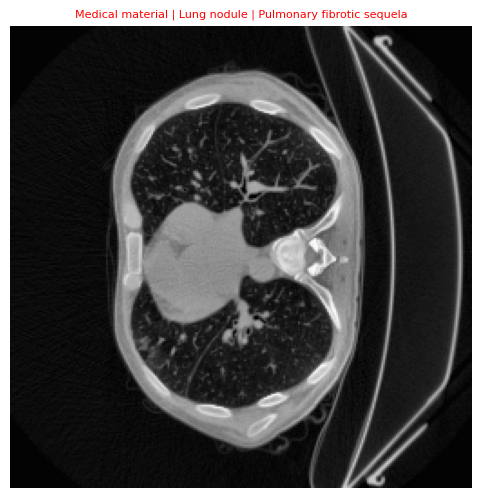

Predicted: ['Medical material', 'Arterial wall calcification', 'Cardiomegaly', 'Pericardial effusion', 'Coronary artery wall calcification', 'Hiatal hernia', 'Lymphadenopathy', 'Atelectasis', 'Lung opacity', 'Pleural effusion', 'Mosaic attenuation pattern', 'Peribronchial thickening', 'Consolidation', 'Interlobular septal thickening'], Actual: ['Lung nodule']


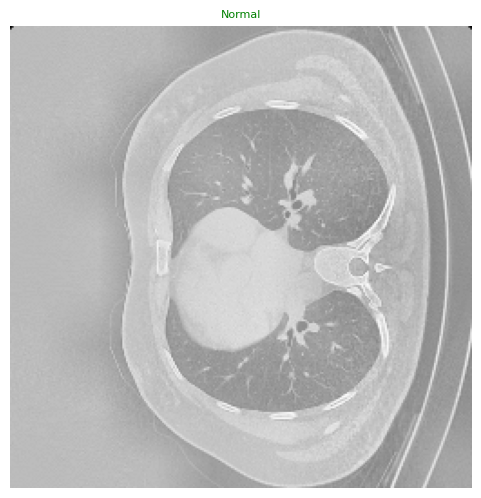

Predicted: ['Arterial wall calcification', 'Hiatal hernia', 'Lymphadenopathy', 'Lung opacity', 'Mosaic attenuation pattern', 'Peribronchial thickening'], Actual: ['Lung nodule']


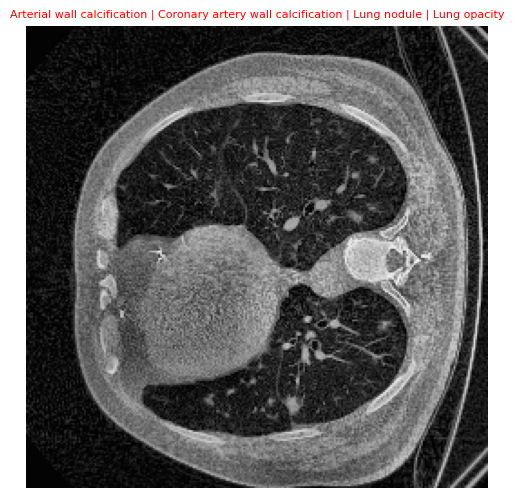

Predicted: ['Arterial wall calcification', 'Cardiomegaly', 'Pericardial effusion', 'Coronary artery wall calcification', 'Hiatal hernia', 'Lymphadenopathy', 'Lung opacity', 'Pleural effusion', 'Mosaic attenuation pattern', 'Peribronchial thickening', 'Consolidation', 'Interlobular septal thickening'], Actual: ['Hiatal hernia', 'Lung nodule', 'Pulmonary fibrotic sequela', 'Peribronchial thickening']


In [ ]:
for imgs, labels in val_loader:
    for i in range(3):
        show_ct_slice(imgs[i], labels[i], val_dataset.label_columns)
        x, y = val_dataset[i]
        x = x.unsqueeze(0).to('cuda')  # tambah batch dim
        with torch.no_grad():
            pred = saved_model(x)                # logits dari model
            probs = torch.sigmoid(pred)          # ubah ke probabilitas 0-1
            pred_labels = (probs > 0.5).int()    # threshold 0.5 → 0/1

        #mapping ke nama label
        pred_label_names = [val_dataset.label_columns[j] for j in range(len(val_dataset.label_columns)) if pred_labels[0, j] == 1]
        actual_label_names = [val_dataset.label_columns[j] for j in range(len(val_dataset.label_columns)) if y[j] == 1]

        print(f'Predicted: {pred_label_names}, Actual: {actual_label_names}')
    break  # cuma tampilkan batch pertama


In [ ]:
def evaluate(y_true, y_pred, threshold=None):
    n_labels = y_true.shape[1]
    results = []
    for i in range(n_labels):
        thr = threshold[i] if threshold is not None else 0.5
        y_pred_binary = (y_pred[:, i] > thr).astype(int)
        TN, FP, FN, TP = confusion_matrix(y_true[:, i], y_pred_binary, labels=[0,1]).ravel()

        ACC = (TP + TN) / (TP + TN + FP + FN + 1e-8) # 1e-8 mencegah misal pembaginya 0
        PREC = TP / (TP + FP + 1e-8)
        RECC = TP / (TP + FN + 1e-8)
        SPEC = TN / (TN + FP + 1e-8)
        FDR = FP / (TP + FP + 1e-8)
        FPR = FP / (TN + FP + 1e-8)
        FNR = FN / (TP + FN + 1e-8)
        NPV = TN / (TN + FN + 1e-8)
        F1 = 2 * (PREC * RECC) / (PREC + RECC + 1e-8)
        MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN) + 1e-8)

        results.append({
            "ACC":ACC,
            "Precision":PREC,
            'Recall': RECC,
            'Specificity': SPEC,
            'F1':F1,
            'FPR':FPR,
            'FNR':FNR,
            'FDR':FDR,
            'NPV':NPV,
            'MCC':MCC
        })
    
    df_eval = pd.DataFrame(results)
    return df_eval

        

Evaluasi training

In [ ]:

from sklearn.metrics import matthews_corrcoef

saved_model.eval()
y_train_true_list = []
y_train_pred_list = []

with torch.no_grad():
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.float().to('cuda'), y_train.float().to('cuda')
        preds = saved_model(X_train)

        y_train_true_list.append(y_train.cpu().numpy())
        y_train_pred_list.append(torch.sigmoid(preds).cpu().numpy())  # sigmoid biar jadi probabilitas

y_true = np.vstack(y_train_true_list)
y_pred = np.vstack(y_train_pred_list)


thresholds = []
for i in range(y_true.shape[1]):
    best_thr, best_mcc = 0.5, 0
    for t in np.arange(0.1, 0.9, 0.05):
        mcc = matthews_corrcoef(y_true[:, i], (y_pred[:, i] > t).astype(int))
        if mcc > best_mcc:
            best_mcc, best_thr = mcc, t
    thresholds.append(best_thr)

df_metrics_train = evaluate(y_true, y_pred, threshold=thresholds)
df_metrics_train

,ACC,Precision,Recall,Specificity,F1,FPR,FNR,FDR,NPV,MCC
0,0.886,0.444444,0.071429,0.988739,0.123077,0.011261,0.928571,0.555556,0.894094,0.142720
1,0.550,0.373737,0.740000,0.468571,0.496644,0.531429,0.260000,0.626263,0.807882,0.194629
2,0.852,0.379310,0.366667,0.918182,0.372881,0.081818,0.633333,0.620690,0.914027,0.289062
3,0.524,0.080321,0.689655,0.513800,0.143885,0.486200,0.310345,0.919679,0.964143,0.095114
4,0.588,0.369748,0.611111,0.578652,0.460733,0.421348,0.388889,0.630252,0.786260,0.172059
5,0.226,0.174569,0.952941,0.077108,0.295082,0.922892,0.047059,0.825431,0.888889,0.043668
6,0.400,0.294264,0.874074,0.224658,0.440299,0.775342,0.125926,0.705736,0.828283,0.109997
7,0.786,0.261905,0.126437,0.924939,0.170543,0.075061,0.873563,0.738095,0.834061,0.070217
8,0.494,0.325301,0.788321,0.382920,0.460554,0.617080,0.211679,0.674699,0.827381,0.161696
9,0.530,0.474453,0.285088,0.735294,0.356164,0.264706,0.714912,0.525547,0.550964,0.022760


Evaluasi validasi

In [ ]:
saved_model.eval()
y_val_true_list = []
y_val_pred_list = []

with torch.no_grad():
    for X_val, y_val in val_loader:
        X_val, y_val = X_val.float().to('cuda'), y_val.float().to('cuda')
        preds = saved_model(X_val)

        y_val_true_list.append(y_val.cpu().numpy())
        y_val_pred_list.append(torch.sigmoid(preds).cpu().numpy())  # sigmoid biar jadi probabilitas

y_true = np.vstack(y_val_true_list)
y_pred = np.vstack(y_val_pred_list)

thresholds = []
for i in range(y_true.shape[1]):
    best_thr, best_mcc = 0.5, 0
    for t in np.arange(0.1, 0.9, 0.05):
        mcc = matthews_corrcoef(y_true[:, i], (y_pred[:, i] > t).astype(int))
        if mcc > best_mcc:
            best_mcc, best_thr = mcc, t
    thresholds.append(best_thr)

df_metrics_val = evaluate(y_true, y_pred, threshold=thresholds)
df_metrics_val

,ACC,Precision,Recall,Specificity,F1,FPR,FNR,FDR,NPV,MCC
0,0.62,0.162162,0.461538,0.643678,0.240000,0.356322,0.538462,0.837838,0.888889,0.073290
1,0.55,0.405797,0.875000,0.397059,0.554455,0.602941,0.125000,0.594203,0.870968,0.274402
2,0.54,0.206897,1.000000,0.477273,0.342857,0.522727,0.000000,0.793103,1.000000,0.314239
3,0.13,0.103093,1.000000,0.033333,0.186916,0.966667,0.000000,0.896907,1.000000,0.058621
4,0.57,0.379310,0.758621,0.492958,0.505747,0.507042,0.241379,0.620690,0.833333,0.231293
5,0.22,0.142857,1.000000,0.103448,0.250000,0.896552,0.000000,0.857143,1.000000,0.121566
6,0.46,0.301370,0.880000,0.320000,0.448980,0.680000,0.120000,0.698630,0.888889,0.195069
7,0.34,0.171053,0.812500,0.250000,0.282609,0.750000,0.187500,0.828947,0.875000,0.053650
8,0.44,0.356322,1.000000,0.188406,0.525424,0.811594,0.000000,0.643678,1.000000,0.259101
9,0.47,0.407407,0.229167,0.692308,0.293333,0.307692,0.770833,0.592593,0.493151,-0.088367


# GRAD CAM BASED VISUALIZATION

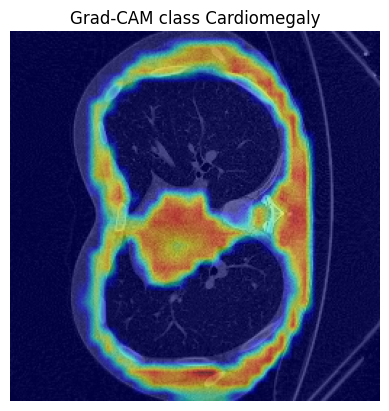

In [ ]:
# Ambil layer terakhir EfficientNet
target_layer = saved_model.feature_extractor[0][-1]

# Hook untuk forward & backward
features, gradients = [], []
def forward_hook(module, input, output):
    features.append(output)
def backward_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0])

target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# Forward pass satu volume
ct_volume, y = val_dataset[0]
x = ct_volume.unsqueeze(0).to('cuda')
pred = saved_model(x)

target_class = 2  # misalnya "lung nodule"
saved_model.zero_grad()
pred[0, target_class].backward(retain_graph=True)

# Ambil feature map & grad
feature_map = features[0]
grad = gradients[0]
weights = grad.mean(dim=(2, 3), keepdim=True)
cam = F.relu((weights * feature_map).sum(dim=1))

# Normalisasi Grad-CAM
cam_np = cam[0].cpu().detach().numpy()
cam_np = (cam_np - cam_np.min()) / (cam_np.max() - cam_np.min())

# Tentukan slice yang ingin ditampilkan
D = ct_volume.shape[1]
slice_top = 10                      # slice ke-10 dari atas
slice_mid = D // 2                  # slice tengah
slice_bottom = D - 10 if D > 20 else D - 2  # slice ke-10 dari bawah

selected_slices = [slice_top, slice_mid, slice_bottom]

# Visualisasi ketiganya
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, idx in enumerate(selected_slices):
    cam_resized = cv2.resize(cam_np, (x.shape[-1], x.shape[-2]))
    cam_resized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min())
    
    axes[i].imshow(ct_volume[0, idx, :, :].cpu(), cmap='gray')
    axes[i].imshow(cam_resized, cmap='jet', alpha=0.4)
    axes[i].set_title(f"Slice {idx} | {val_dataset.label_columns[target_class]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()
